# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [0]:
!pip3 -qq install torch==0.4.1
!pip3 -qq install bokeh==0.13.0
!pip3 -qq install gensim==3.6.0
!pip3 -qq install nltk
!pip3 -qq install scikit-learn==0.20.2

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [0]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Пример размеченного предложения:

In [0]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


In [0]:
' '.join([word for word,tag in data[0]])

"The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place ."

In [0]:
len(data)

57340

Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [0]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [0]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'PRT', 'PRON', 'NOUN', 'DET', 'ADV', 'ADJ', 'ADP', 'VERB', 'NUM', 'X', '.', 'CONJ'}


In [0]:
word2ind['passion']

28157

In [0]:
word2ind['room']

33147

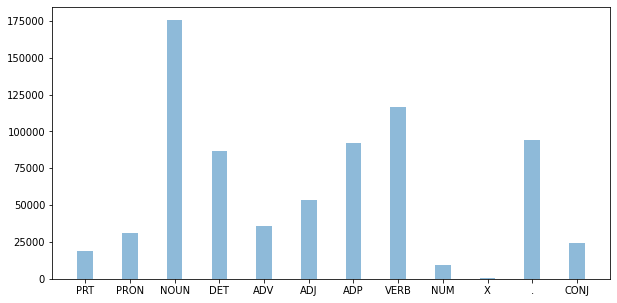

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [0]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [0]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [0]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [0]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [0]:
import pandas as pd
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160
0,26695,29413.0,18176.0,29269.0,28273.0,7568.0,15857.0,20245.0,1229.0,17300.0,33545.0,17555.0,12965.0,23205.0,17217.0,40730.0,13891.0,37813.0,37813.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36695,17341.0,14391.0,12965.0,23205.0,22945.0,36953.0,23205.0,11091.0,1861.0,27083.0,22876.0,13328.0,22298.0,23269.0,17542.0,36953.0,23205.0,40773.0,6217.0,29205.0,29539.0,34769.0,36953.0,23205.0,36826.0,2931.0,37890.0,1255.0,5757.0,13328.0,36953.0,23205.0,34929.0,35574.0,6678.0,32301.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29909,26485.0,23361.0,18123.0,35314.0,26822.0,4259.0,22298.0,14513.0,21661.0,1229.0,28420.0,23572.0,31256.0,37765.0,12965.0,5604.0,36953.0,13414.0,3382.0,5689.0,39879.0,22519.0,27083.0,23550.0,28234.0,23550.0,4259.0,3919.0,25913.0,1229.0,19548.0,1067.0,27083.0,28234.0,31784.0,30104.0,1067.0,27083.0,33545.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,41978,3856.0,23977.0,36205.0,16146.0,20440.0,23205.0,16457.0,3856.0,44841.0,32301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26695,22021.0,38387.0,13350.0,13891.0,27083.0,1328.0,33065.0,32301.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160
0,11,4.0,8.0,2.0,8.0,7.0,3.0,3.0,7.0,3.0,12.0,3.0,7.0,4.0,6.0,3.0,11.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,4.0,3.0,7.0,4.0,6.0,7.0,4.0,6.0,3.0,11.0,3.0,8.0,4.0,6.0,3.0,7.0,4.0,3.0,4.0,8.0,4.0,3.0,7.0,4.0,5.0,8.0,6.0,3.0,3.0,8.0,7.0,4.0,6.0,6.0,3.0,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,3.0,8.0,5.0,8.0,8.0,7.0,4.0,8.0,3.0,7.0,8.0,3.0,6.0,3.0,7.0,3.0,7.0,5.0,5.0,6.0,3.0,3.0,11.0,5.0,5.0,7.0,7.0,4.0,3.0,7.0,3.0,3.0,11.0,5.0,8.0,3.0,3.0,11.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,6.0,3.0,5.0,8.0,7.0,4.0,6.0,6.0,3.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,2.0,8.0,5.0,11.0,11.0,8.0,3.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
for w in word2ind.keys():
  if word2ind[w] == 4558:
    print(w)
    break
word2ind[w]

stein


4558

In [0]:
tag2ind

{'.': 11,
 '<pad>': 0,
 'ADJ': 6,
 'ADP': 7,
 'ADV': 5,
 'CONJ': 12,
 'DET': 4,
 'NOUN': 3,
 'NUM': 9,
 'PRON': 2,
 'PRT': 1,
 'VERB': 8,
 'X': 10}

In [0]:
X_train[0][:5]

[26695, 29413, 18176, 29269, 28273]

In [0]:
train_data[0]

[('``', '.'),
 ('What', 'DET'),
 ('did', 'VERB'),
 ('you', 'PRON'),
 ('think', 'VERB'),
 ('about', 'ADP'),
 ("Bang-Jensen's", 'NOUN'),
 ('contention', 'NOUN'),
 ('of', 'ADP'),
 ('errors', 'NOUN'),
 ('and', 'CONJ'),
 ('omissions', 'NOUN'),
 ('in', 'ADP'),
 ('the', 'DET'),
 ('Hungarian', 'ADJ'),
 ('report', 'NOUN'),
 ("''", '.'),
 ('?', '.'),
 ('?', '.')]

In [0]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [0]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((34, 4), (34, 4))

In [0]:
X_batch[0][0]

15288.0

In [0]:
len(tag2ind)

13

**Задание** Реализуйте `LSTMTagger`:

In [0]:
# got from https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()    
        self.lstm_hidden_dim = lstm_hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim)
        
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)
        

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        linear_res = self.hidden2tag(lstm_out)
       # tag_space = self.hidden2tag(lstm_out.view(inputs.numel(), -1))
       # tag_scores = F.log_softmax(tag_space, dim=1)
        return linear_res

In [0]:
(X_batch[0],y_batch[0])

(array([15288., 10492., 41245., 23205.]), array([10.,  3.,  8.,  4.]))

In [0]:
y_batch

array([[10.,  3.,  8.,  4.],
       [ 3.,  3.,  7.,  3.],
       [ 7., 11.,  3.,  8.],
       [ 4.,  2.,  5.,  6.],
       [ 3.,  8.,  7., 11.],
       [11.,  3.,  3.,  4.],
       [ 4., 10., 11.,  3.],
       [ 3., 10.,  3.,  6.],
       [ 7.,  7.,  8., 12.],
       [ 3.,  4.,  4.,  8.],
       [11.,  8.,  3., 11.],
       [ 2.,  3.,  7., 12.],
       [ 8., 11.,  4.,  1.],
       [11.,  8.,  6.,  8.],
       [ 0.,  9.,  3.,  5.],
       [ 0.,  5., 11.,  8.],
       [ 0.,  6.,  4.,  1.],
       [ 0.,  7.,  3.,  8.],
       [ 0.,  4.,  7.,  6.],
       [ 0.,  3.,  4.,  3.],
       [ 0.,  7.,  4.,  7.],
       [ 0.,  3.,  3.,  2.],
       [ 0., 11.,  8., 11.],
       [ 0.,  0.,  8.,  0.],
       [ 0.,  0.,  8.,  0.],
       [ 0.,  0.,  8.,  0.],
       [ 0.,  0.,  2.,  0.],
       [ 0.,  0.,  5.,  0.],
       [ 0.,  0.,  4.,  0.],
       [ 0.,  0.,  6.,  0.],
       [ 0.,  0.,  3.,  0.],
       [ 0.,  0., 11.,  0.]])

In [0]:
mask = (torch.LongTensor(y_batch)!=0).float()
mask

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [0]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)
print('logits shape', logits.shape)
indices = torch.argmax(logits,-1)
pred = (indices==y_batch).float()
print("pred shape", pred.shape)
mask = (torch.LongTensor(y_batch)!=0).float() 
correct_samples = torch.sum(pred*mask)
print('correct_samples shape', correct_samples.shape)
all_samples = torch.sum(mask)
accuracy = correct_samples/all_samples
print(accuracy)

def get_accuracy(logits, y_batch):
    labels = torch.argmax(logits.view(y_batch.size()[0], y_batch.size()[1], -1), dim=2)

    accuracy = float(torch.sum(labels == y_batch)) / labels.numel()
    return accuracy

#<calc accuracy>
#accuracy = get_accuracy(logits, y_batch)
#accuracy

logits shape torch.Size([34, 4, 13])
pred shape torch.Size([34, 4])
correct_samples shape torch.Size([])
tensor(0.0746)


In [0]:
tag2ind

{'.': 11,
 '<pad>': 0,
 'ADJ': 6,
 'ADP': 7,
 'ADV': 5,
 'CONJ': 12,
 'DET': 4,
 'NOUN': 3,
 'NUM': 9,
 'PRON': 2,
 'PRT': 1,
 'VERB': 8,
 'X': 10}

In [0]:
logits.transpose(2, 1).shape, y_batch.shape

(torch.Size([34, 13, 4]), torch.Size([34, 4]))

In [0]:
type(logits)

torch.Tensor

In [0]:
criterion = nn.CrossEntropyLoss()
loss = float(criterion(logits.transpose(2,1), y_batch))
loss

2.646315574645996

In [0]:
logits.transpose(2,1).shape

torch.Size([32, 13, 4])

In [0]:
y_batch.shape

torch.Size([32, 4])

**Задание** Вставьте эти вычисление в функцию:

In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                loss = criterion(logits.view(-1, logits.shape[-1]), y_batch.view(-1))

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                preds = torch.argmax(logits, dim=-1)

                mask = (y_batch != 0).float()
                cur_correct_count = ((preds == y_batch).float() * mask).sum().item()
                cur_sum_count = mask.sum().item()
                
                # cur_correct_count, cur_sum_count = <calc accuracy>

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count



def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size


    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [0]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.30635, Accuracy = 72.16%: 100%|██████████| 572/572 [00:06<00:00, 91.42it/s]
[1 / 50]   Val: Loss = 0.10136, Accuracy = 85.34%: 100%|██████████| 13/13 [00:00<00:00, 79.60it/s]
[2 / 50] Train: Loss = 0.10004, Accuracy = 90.00%: 100%|██████████| 572/572 [00:06<00:00, 93.88it/s]
[2 / 50]   Val: Loss = 0.07033, Accuracy = 89.81%: 100%|██████████| 13/13 [00:00<00:00, 76.89it/s]
[3 / 50] Train: Loss = 0.06734, Accuracy = 93.23%: 100%|██████████| 572/572 [00:06<00:00, 94.10it/s]
[3 / 50]   Val: Loss = 0.06319, Accuracy = 91.39%: 100%|██████████| 13/13 [00:00<00:00, 75.01it/s]
[4 / 50] Train: Loss = 0.05041, Accuracy = 94.84%: 100%|██████████| 572/572 [00:06<00:00, 93.91it/s]
[4 / 50]   Val: Loss = 0.05974, Accuracy = 92.24%: 100%|██████████| 13/13 [00:00<00:00, 77.95it/s]
[5 / 50] Train: Loss = 0.04051, Accuracy = 95.85%: 100%|██████████| 572/572 [00:06<00:00, 93.81it/s]
[5 / 50]   Val: Loss = 0.06239, Accuracy = 92.74%: 100%|██████████| 13/13 [00:00<00:00, 79.28it/s]


In [0]:
len(X_train), len(y_train)

(36554, 36554)

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [0]:
current_count = 0
sum_count = 0
for i,(X_batch, y_batch) in enumerate(iterate_batches((X_train, y_train), 64)):
  X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
  logits = model(X_batch)
  indices = torch.argmax(logits,-1)
  pred = (indices==y_batch).float()

  mask = (y_batch!=0).float() 
  correct_count = torch.sum(pred*mask)
  sum_count = torch.sum(mask)
  accuracy = correct_samples/all_samples

correct_count/sum_count

tensor(0.9961, device='cuda:0')

### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [0]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()    
        self.lstm_hidden_dim = lstm_hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, bidirectional = True)
        
        self.hidden2tag = nn.Linear(lstm_hidden_dim*2, tagset_size)
        

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        linear_res = self.hidden2tag(lstm_out)
       # tag_space = self.hidden2tag(lstm_out.view(inputs.numel(), -1))
       # tag_scores = F.log_softmax(tag_space, dim=1)
        return linear_res

In [0]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=30,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 30] Train: Loss = 0.31934, Accuracy = 71.05%: 100%|██████████| 572/572 [00:06<00:00, 95.20it/s] 
[1 / 30]   Val: Loss = 0.09402, Accuracy = 85.55%: 100%|██████████| 13/13 [00:00<00:00, 77.83it/s]
[2 / 30] Train: Loss = 0.09914, Accuracy = 89.97%: 100%|██████████| 572/572 [00:06<00:00, 95.20it/s]
[2 / 30]   Val: Loss = 0.07203, Accuracy = 89.58%: 100%|██████████| 13/13 [00:00<00:00, 79.52it/s]
[3 / 30] Train: Loss = 0.06738, Accuracy = 93.18%: 100%|██████████| 572/572 [00:05<00:00, 95.46it/s]
[3 / 30]   Val: Loss = 0.06304, Accuracy = 91.36%: 100%|██████████| 13/13 [00:00<00:00, 77.81it/s]
[4 / 30] Train: Loss = 0.05070, Accuracy = 94.78%: 100%|██████████| 572/572 [00:06<00:00, 95.01it/s]
[4 / 30]   Val: Loss = 0.05728, Accuracy = 92.19%: 100%|██████████| 13/13 [00:00<00:00, 76.24it/s]
[5 / 30] Train: Loss = 0.04054, Accuracy = 95.81%: 100%|██████████| 572/572 [00:06<00:00, 94.75it/s]
[5 / 30]   Val: Loss = 0.05602, Accuracy = 92.67%: 100%|██████████| 13/13 [00:00<00:00, 73.28it/s]

### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [0]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Построим подматрицу для слов из нашей тренировочной выборки:

In [0]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


In [0]:
w2v_model.vectors.shape[1]

100

**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        
        self.word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings))
        
        self.lstm = nn.LSTM(embeddings.shape[1], lstm_hidden_dim, num_layers = lstm_layers_count)
        
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)
        

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        linear_res = self.hidden2tag(lstm_out)
       # tag_space = self.hidden2tag(lstm_out.view(inputs.numel(), -1))
       # tag_scores = F.log_softmax(tag_space, dim=1)
        return linear_res

In [0]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.75088, Accuracy = 77.97%: 100%|██████████| 572/572 [00:04<00:00, 129.06it/s]
[1 / 50]   Val: Loss = 0.37344, Accuracy = 89.15%: 100%|██████████| 13/13 [00:00<00:00, 88.28it/s]
[2 / 50] Train: Loss = 0.28881, Accuracy = 91.34%: 100%|██████████| 572/572 [00:04<00:00, 130.63it/s]
[2 / 50]   Val: Loss = 0.26206, Accuracy = 91.98%: 100%|██████████| 13/13 [00:00<00:00, 77.59it/s]
[3 / 50] Train: Loss = 0.21246, Accuracy = 93.38%: 100%|██████████| 572/572 [00:04<00:00, 123.21it/s]
[3 / 50]   Val: Loss = 0.21389, Accuracy = 93.29%: 100%|██████████| 13/13 [00:00<00:00, 84.69it/s]
[4 / 50] Train: Loss = 0.17566, Accuracy = 94.42%: 100%|██████████| 572/572 [00:04<00:00, 131.86it/s]
[4 / 50]   Val: Loss = 0.18707, Accuracy = 94.05%: 100%|██████████| 13/13 [00:00<00:00, 85.94it/s]
[5 / 50] Train: Loss = 0.15357, Accuracy = 95.05%: 100%|██████████| 572/572 [00:04<00:00, 132.25it/s]
[5 / 50]   Val: Loss = 0.17166, Accuracy = 94.45%: 100%|██████████| 13/13 [00:00<00:00, 84.56i

In [0]:
embeddings.shape

(45441, 100)

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [0]:
#<calc test accuracy>
current_count = 0
sum_count = 0
for i,(X_batch, y_batch) in enumerate(iterate_batches((X_train, y_train), 64)):
  X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
  logits = model(X_batch)
  indices = torch.argmax(logits,-1)
  pred = (indices==y_batch).float()

  mask = (y_batch!=0).float() 
  correct_count = torch.sum(pred*mask)
  sum_count = torch.sum(mask)
  accuracy = correct_samples/all_samples

correct_count/sum_count

tensor(0.9851, device='cuda:0')